In [1]:
import pandas as pd

df = pd.read_csv("SMSSpamCollection", sep="\t", header=None, names=["Label", "Message"])
# header - cabecalho (None, nao tem cabecalho) #sep \t por se tratar de um arquivo tsv
display(df) #df = data frame


,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Label
ham     4825
spam     747
Name: count, dtype: int64


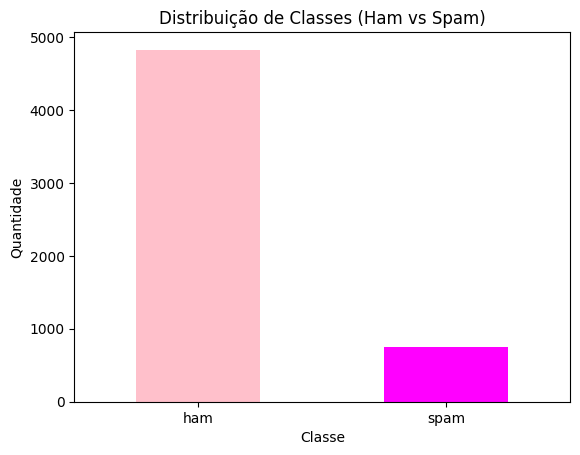

In [2]:
import matplotlib.pyplot as plt

contagem = df['Label'].value_counts()
print(contagem)
contagem.plot(kind='bar', title="Distribuição de Classes (Ham vs Spam)", color=["pink", "magenta"])
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.xticks(rotation=0) # horizontal
plt.show()

In [3]:
df["Word_count"] = df["Message"].apply(lambda x: len(x.split())) # Número de palavras por documento
# Split divide o texto em palavras usando espaço como separador
display(df)

,Label,Message,Word_count
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30
5568,ham,Will ü b going to esplanade fr home?,8
5569,ham,"Pity, * was in mood for that. So...any other s...",10
5570,ham,The guy did some bitching but I acted like i'd...,26


In [4]:
df["Word_count"].describe() #Alguns dados
# Count: número de mensagens
# Mean: média de palavras por mensagem
# Std: desvio padrão (o quanto as mensagens variam em relação à média)
# Min: a menor mensagem tem uma palavra
# 25%: 25% das mensagens têm até 7 palavras
# Max: a maior mensagem tem 171 palavras

count    5572.000000
mean       15.597452
std        11.404053
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       171.000000
Name: Word_count, dtype: float64

In [5]:
#Iniciando pré-processamento de Dados (Passo 2)

#Passo 1 - Converter para minúsculas, remover acentuação, e stopwords
import nltk
import unicodedata
from nltk.corpus import stopwords

# nltk.download('stopwords') #Lista de stopwords

# stopwords_pt = set(stopwords.words('portuguese')) # Lista em português

stopwords_en = set(stopwords.words('english')) # Lista em português


def processar_etapa1(texto):
    texto = texto.lower() # Coloca tudo em minúsculo
    
    # remove acentuação
    texto = ''.join( # depois de filtrar, junta tudo de novo em uma string normal
        caractere for caractere in unicodedata.normalize('NFD', texto) # Quebra os caracteres acentuados (ex.: ç = c, cedilha)
        if unicodedata.category(caractere) != 'Mn' # Mn = Mark, Nonspacing (acentos, tils, cedilhas...)
    )

    tokens = texto.split() # quebra em tokens
    tokens = [t for t in tokens if t not in stopwords_en]

    return ' '.join(tokens) # junta novamente em uma string

df["Message_clean"] = df["Message"].apply(processar_etapa1)
display(df)

,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,"go jurong point, crazy.. available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...,6,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor... u c already say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,"nah think goes usf, lives around though"
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,2nd time tried 2 contact u. u £750 pound prize...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...",10,"pity, * mood that. so...any suggestions?"
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [6]:
# Passo 2 - Remoção de marcações
import re
df["Message_clean"] = df["Message_clean"].apply(lambda x: re.sub(r"[@#][\w@]+", "", x))
# r"[@#]\w+" -> busca o que deve ser removido
# "" -> o que deve ser substituído (nada)
display(df)


,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,"go jurong point, crazy.. available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...,6,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor... u c already say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,"nah think goes usf, lives around though"
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,2nd time tried 2 contact u. u £750 pound prize...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...",10,"pity, * mood that. so...any suggestions?"
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [7]:
# Passo 4: remover urls (http e www)

def remover_urls(texto):
    return re.sub(r'(http[s]?://\S+|www\.\S+)', '', texto, flags=re.IGNORECASE)
    # re.sub (padrao, substituo, texto)
    # http\S+ -> pega tudo que comeca com http e segue com qualquer coisa que nao seja espaço
    # www\.\S+ -> pega tudo que comeca com www. seguido pos algo que nao seja espaço

df["Message_clean"] = df["Message_clean"].apply(remover_urls)
display(df)

,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,"go jurong point, crazy.. available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...,6,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor... u c already say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,"nah think goes usf, lives around though"
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,2nd time tried 2 contact u. u £750 pound prize...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...",10,"pity, * mood that. so...any suggestions?"
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [8]:
# Passo 3 - Reduzir repetições (máximo duas ocorrências)
# Exemplo: boaaaaaaa -> boaa

def reduzir_repeticoes(texto):
    return re.sub(r'(.)\1{2,}', r'\1\1', texto)
    # (.) -> captura qualquer caractere
    # \1 refere-se ao mesmo caractere capturado
    # {2,} -> casa com duas ou mais repetições do mesmo caractere
    # r'\1\1 -> substitui por duas ocorrencias desse caractere

df["Message_clean"] = df["Message_clean"].apply(reduzir_repeticoes)
display(df)


,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,"go jurong point, crazy.. available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...,6,ok lar.. joking wif u oni..
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor.. u c already say..
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,"nah think goes usf, lives around though"
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,2nd time tried 2 contact u. u £750 pound prize...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...",10,"pity, * mood that. so..any suggestions?"
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [9]:
# Passo 5: remover pontuação

import string

df["Message_clean"] = df["Message_clean"].str.translate(str.maketrans('', '', string.punctuation))
display(df)

,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think goes usf lives around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,2nd time tried 2 contact u u £750 pound prize ...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",10,pity mood that soany suggestions
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [10]:

# Passo 6: remover entidades referentes à localizações e organizações
#Esse caso é para textos em inglês

from nltk import word_tokenize, ne_chunk, pos_tag
from nltk.tree import Tree

nltk.download('punkt')           
nltk.download('averaged_perceptron_tagger')  
nltk.download('maxent_ne_chunker')  
nltk.download('words')  

def remover_entidades_localizacao_organizacao(texto):
    tokens = word_tokenize(texto)
    tags = pos_tag(tokens)
    ner = ne_chunk(tags)
    entidades = []
    for subtree in ner:
        if isinstance(subtree, Tree):
            entidade = " ".join([token for token, pos in subtree.leaves()])
            entidades.append(entidade)
    return ' '.join([w for w in tokens if w not in entidades])

print(remover_entidades_localizacao_organizacao("I visited Microsoft in New York yesterday"))

#df["Message_clean"] = df["Message_clean"].apply(remover_entidades_localizacao_organizacao)
#display(df)




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ester\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ester\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\ester\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ester\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\ester/nltk_data'
    - 'c:\\Users\\ester\\AppData\\Local\\Programs\\Python\\Python313\\nltk_data'
    - 'c:\\Users\\ester\\AppData\\Local\\Programs\\Python\\Python313\\share\\nltk_data'
    - 'c:\\Users\\ester\\AppData\\Local\\Programs\\Python\\Python313\\lib\\nltk_data'
    - 'C:\\Users\\ester\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [ ]:
# Etapa 7: remover tokens numéricos

def remover_tokens_numericos(texto):
    tokens = texto.split()
    tokens_sem_numeros = [t for t in tokens if not re.search(r'\d', t)]
    return ' '.join(tokens_sem_numeros)

df["Message_clean"] = df["Message_clean"].apply(remover_tokens_numericos)
display(df)

,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts may...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think goes usf lives around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,time tried contact u u pound prize claim easy ...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",10,pity mood that soany suggestions
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [ ]:
# Etapa 8: remover palavras com menos de 3 caracteres

def remover_palavras_curtas(texto):
    tokens = texto.split()
    tokens_sem_palavras_curtas = [t for t in tokens if len(t) >= 3]
    return ' '.join(tokens_sem_palavras_curtas)

df["Message_clean"] = df["Message_clean"].apply(remover_palavras_curtas)
display(df)


,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,6,lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win cup final tkts may te...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think goes usf lives around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,time tried contact pound prize claim easy call...
5568,ham,Will ü b going to esplanade fr home?,8,going esplanade home
5569,ham,"Pity, * was in mood for that. So...any other s...",10,pity mood that soany suggestions
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [ ]:
# Etapa 9: remover nomes pessoais



In [ ]:
""""
# Tokenização

from nltk.tokenize import word_tokenize

df["Message_clean"] = df["Message_clean"].apply(word_tokenize)
display(df)

"""

'"\n# Tokenização\n\nfrom nltk.tokenize import word_tokenize\n\ndf["Message_clean"] = df["Message_clean"].apply(word_tokenize)\ndisplay(df)\n\n'

In [ ]:
# Passo 3: Representação TF-IDF 

from sklearn.feature_extraction.text import TfidfVectorizer
"""
vectorizer = TfidfVectorizer()

tfidf = vectorizer.fit_transform(df["Message_clean"])

print("Vocabulário:", vectorizer.get_feature_names_out()[:20])
print(tfidf.toarray()[:5])
"""
#teste: 
docs = [
    "gostei muito do produto",
    "produto com defeito",
    "serviço excelente e rápido",
    "não gostei do atendimento",
    "produto bom e atendimento ótimo"
]

vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(docs)

print("Vocabulário:", vectorizer.get_feature_names_out())

df_tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out())
print(df_tfidf)


Vocabulário: ['atendimento' 'bom' 'com' 'defeito' 'do' 'excelente' 'gostei' 'muito'
 'não' 'produto' 'rápido' 'serviço' 'ótimo']
   atendimento       bom      com  defeito        do  excelente    gostei  \
0     0.000000  0.000000  0.00000  0.00000  0.486484    0.00000  0.486484   
1     0.000000  0.000000  0.63907  0.63907  0.000000    0.00000  0.000000   
2     0.000000  0.000000  0.00000  0.00000  0.000000    0.57735  0.000000   
3     0.469515  0.000000  0.00000  0.00000  0.469515    0.00000  0.469515   
4     0.458270  0.568014  0.00000  0.00000  0.000000    0.00000  0.000000   

      muito       não   produto   rápido  serviço     ótimo  
0  0.602985  0.000000  0.403826  0.00000  0.00000  0.000000  
1  0.000000  0.000000  0.427993  0.00000  0.00000  0.000000  
2  0.000000  0.000000  0.000000  0.57735  0.57735  0.000000  
3  0.000000  0.581951  0.000000  0.00000  0.00000  0.000000  
4  0.000000  0.000000  0.380406  0.00000  0.00000  0.568014  
